# Belgium

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

## Fetch results

In [2]:
# File manually copied from source code over at
# https://wahlergebnisse.belgium.be/de/search/europ%C3%A4isches-parlament/2019/kanton
df = pd.read_json('../../data/2019/raw/bel_cantons.json')

In [3]:
def get_canton_data(canton_id):
    url = f'https://wahlergebnisse.belgium.be/de/election-results/europ%C3%A4isches-parlament/2019/kanton/{canton_id}'
    resp = requests.get(url)
    soup = BeautifulSoup(resp.text)
    num_total = 0
    num_votes = 0
    for elem in soup.select_one('.pb-3').select('strong'):
        if elem.text.strip() == 'Eingetragene Wähler:':
            num_total = int(elem.next_sibling.strip())
        elif elem.text.strip() == 'Abgegebene Stimmen:':
            num_votes = int(elem.next_sibling.strip())
    return {
        'canton_id': canton_id,
        'total': num_total,
        'votes': num_votes,
        'turnout': round(num_votes / num_total * 100, 2)
    }

In [4]:
%%time
df['data'] = df.id.apply(get_canton_data)

CPU times: user 9.84 s, sys: 380 ms, total: 10.2 s
Wall time: 37.5 s


In [26]:
df['total'] = df['total'].astype(int)
df['votes'] = df['votes'].astype(int)
df['turnout'] = df['turnout'].astype(float)

In [5]:
df = pd.merge(df, pd.DataFrame(df.data.to_list()), left_on='id', right_on='canton_id')
df = df.drop(['data', 'canton_id'], axis=1)

In [6]:
df['label'] = df['label'].str.replace('Kanton ', '')

df['label'] = df.label.str.replace('&#xE8;', 'è')
df['label'] = df.label.str.replace('&#xE2;', 'â')
df['label'] = df.label.str.replace('&#xE9;', 'é')
df['label'] = df.label.str.replace('&#xEA;', 'ê')
df['label'] = df.label.str.replace('&#xFC;', 'u')
df['label'] = df.label.str.replace('&#x27;', "'")
df['label'] = df.label.str.replace('&#xE0;', 'à')
df['label'] = df.label.str.replace('&#xF6;', 'ö')

In [27]:
df.to_csv('../../data/2019/raw/bel.csv', index=False)

In [39]:
df = pd.read_csv('../../data/2019/raw/bel.csv', dtype={'id': str})

## Merge

In [40]:
geo = gpd.read_file('../../data/2019/shapefiles/bel/electoralcanton_3812.shp', encoding='utf8')
geo = geo.to_crs(epsg=4326)

In [41]:
geo.cantonhead = (geo.cantonhead
    .replace('Ixelles Elsene', 'Ixelles')
    .replace('Bruxelles Brussel', 'Bruxelles')
    .replace('Uccle Ukkel', 'Uccle')
    .replace('Saint-Gilles Sint-Gillis', 'Saint-Gilles')
    .replace('Saint-Josse-ten-Noode Sint-Joost-ten-Node', 'Saint-Josse-Ten-Noode')
    .replace('Molenbeek-Saint-Jean Sint-Jans-Molenbeek', 'Molenbeek-Saint-Jean')
    .replace('Schaerbeek Schaarbeek', 'Schaerbeek')
    .replace('Oostende', 'Ostende')
    .replace('Mechelen', 'Mecheln')
    .replace('Puurs-Sint-Amands', 'Puurs-Saint-Amands')
    .replace('Tongeren', 'Tongern')
    .replace('Ieper', 'Ypern')
    .replace('Sint-Genesius-Rode', 'Rhode-Saint-Genèse')
    .replace('Diksmuide', 'Dixmuiden')
    .replace('Leuven', 'Löwen')
    .replace('Liège', 'Luttich')
    .replace('Heuvelland', 'Mesen')
    .replace('Waregem', 'Harelbeke')
    .replace('Sankt-Vith', 'Sankt Vith')
    .replace('Bruxelles', 'Brussel')
    .replace('Limbourg', 'Limburg'))

In [42]:
geo = geo.merge(df, left_on='cantonhead', right_on='label', how='left')

In [43]:
geo[geo['label'].isna()].shape

(0, 10)

In [44]:
geo = geo[['cantonhead', 'geometry', 'turnout']]
geo = geo.rename(columns={'cantonhead': 'name'})

## Export

In [45]:
geo['country'] = 'bel'

In [46]:
geo.to_file('../../data/2019/processed/bel', encoding='utf8')

## Visualize

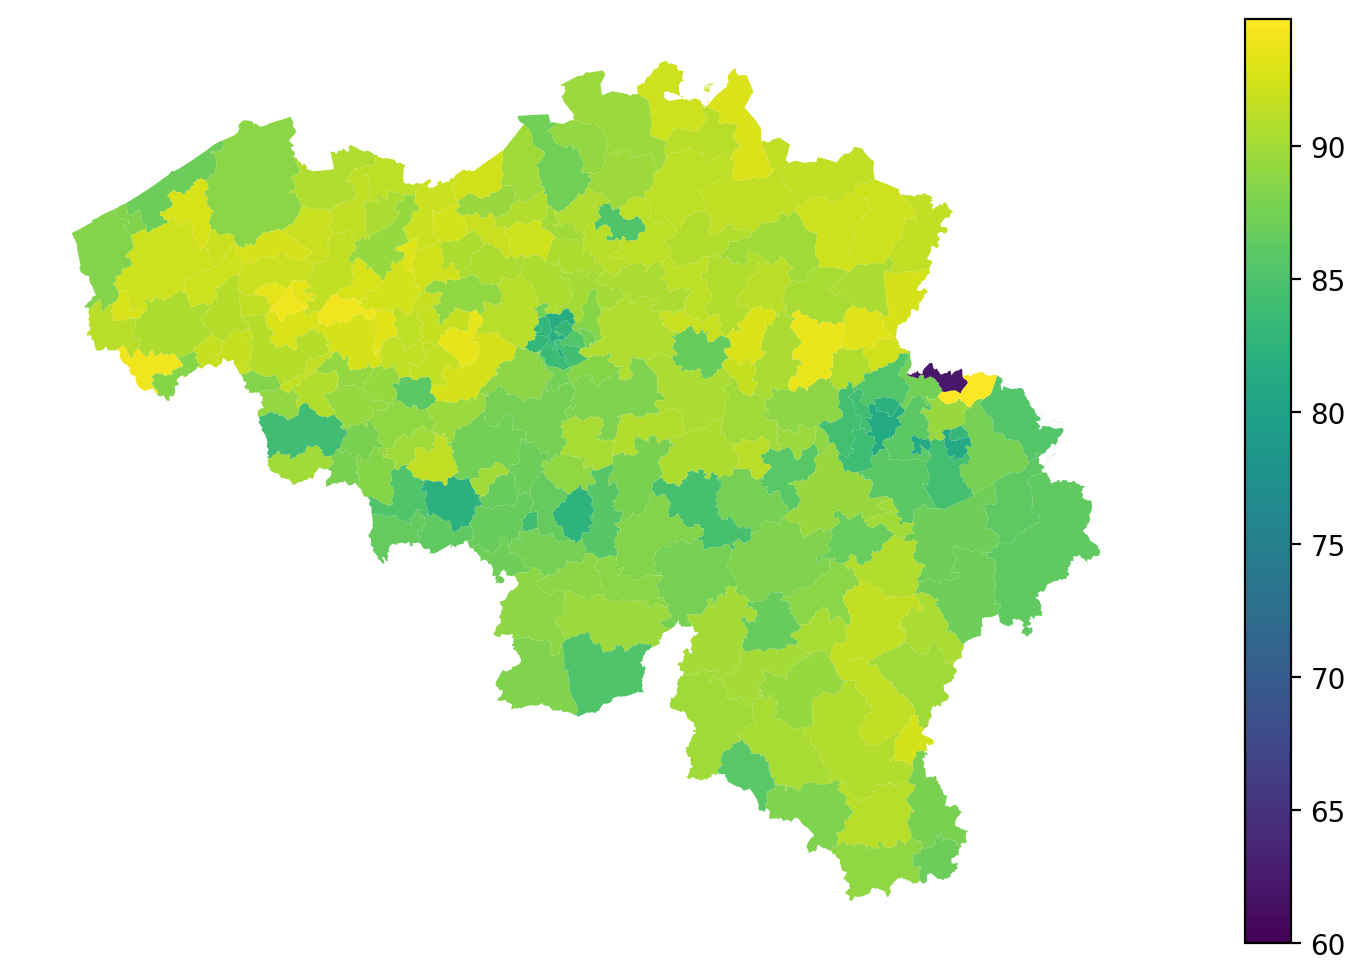

In [47]:
ax = geo.plot(figsize=(12, 6), column='turnout', vmin=60, legend=True);
fig = ax.get_figure()
fig.set_facecolor('#ffffff')
ax.set_axis_off()
fig.savefig('../../reports/bel_choropleth.png')